In [ ]:
"""
SUMMARY:
Amazon pos/neg sentiment classification

Accuracy: 0.94
Time per Epoch: 9550 seconds = 220 rev/s
Total time: 9550*10 = 1592 min = 26.5 hours
Train size = 2,097,152
Test size = 233,016

DETAILS:
Attempt to replicate crepe model using MXNET:
https://github.com/zhangxiangxiao/Crepe

This uses an efficient numpy array (dtype=bool)
to hold all data in RAM. 

Run on one GPU (Tesla K80) with batch=128
Peak RAM: 142GB, and training cut to: 2,097,152 (from 3.6M)
"""

In [8]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import mxnet as mx
import wget
import time
import os.path
import math
import matplotlib.pyplot as plt
import logging

In [9]:
AZ_ACC = "amazonsentimenik"
AZ_CONTAINER = "textclassificationdatasets"

ALPHABET = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}")
FEATURE_LEN = 1014
BATCH_SIZE = 128
NUM_FILTERS = 256
DATA_SHAPE = (BATCH_SIZE, 1, FEATURE_LEN, len(ALPHABET))

ctx = mx.gpu(1)
EPOCHS = 10
SD = 0.05  # std for gaussian distribution
NOUTPUT = 2  # good or bad
INITY = mx.init.Normal(sigma=SD)
LR = 0.01
MOMENTUM = 0.9
WDECAY = 0.00001

In [10]:
# logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='crepe_amazon.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [11]:
def download_file(url):
    # Create file-name
    local_filename = url.split('/')[-1]
    if os.path.isfile(local_filename):
        pass
        # print("The file %s already exist in the current directory\n" % local_filename)
    else:
        # Download
        print("downloading ...\n")
        wget.download(url)
        print('\nsaved data')

In [12]:
def load_data_frame(infile, shuffle = False):
    print("processing data frame: %s" % infile)
    # Get data from windows blob
    download_file('https://%s.blob.core.windows.net/%s/%s' % (AZ_ACC, AZ_CONTAINER, infile))
    
    # 3.6 mill is too much, use 2 mill (keep same ratio)
    if "test" in infile:
        maxrows = int(2097152/9)  # 16,384 batches
    elif "train" in infile:
        maxrows = int(2097152)

    # load data into dataframe
    df = pd.read_csv(infile,
                     header=None,
                     names=['sentiment', 'summary', 'text'],
                     nrows=maxrows)
    # Shuffle
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
        
    # concat summary, review; trim to 1014 char; reverse; lower
    df['rev'] = df.apply(lambda x: "%s %s" % (x['summary'], x['text']), axis=1)
    df.rev = df.rev.str[:FEATURE_LEN].str[::-1].str.lower()
    
    # store class as nparray
    df.sentiment -= 1
    y_split = np.asarray(df.sentiment, dtype='int')
    # drop columns
    df.drop(['text', 'summary', 'sentiment'], axis=1, inplace=True)

    # Dictionary to create character vectors
    character_hash = pd.DataFrame(np.identity(len(ALPHABET), dtype='bool'), columns=ALPHABET)
    print("finished processing data frame: %s" % infile)
    print("data contains %d obs" % df.shape[0])
    batch_size = df.shape[0]
    # Create encoding
    X_split = np.zeros([batch_size, 1, FEATURE_LEN, len(ALPHABET)], dtype='bool')
    # Main loop
    for ti, tx in enumerate(df.rev):
        if (ti+1) % (100*1000) == 0:
            print("Processed: ", ti+1)
        chars = list(tx)
        for ci, ch in enumerate(chars):
            if ch in ALPHABET:
                X_split[ti % batch_size][0][ci] = np.array(character_hash[ch], dtype='bool')
                
    # Return as a DataBatch
    #return DataBatch(data=[mx.nd.array(X_split)],
    #                 label=[mx.nd.array(y_split[ti + 1 - batch_size:ti + 1])])
    return X_split, y_split

In [13]:
def create_crepe():
    """
    Replicating: https://github.com/zhangxiangxiao/Crepe/blob/master/train/config.lua
    """
    input_x = mx.sym.Variable('data')  # placeholder for input
    input_y = mx.sym.Variable('softmax_label')  # placeholder for output
    # 1. alphabet x 1014
    conv1 = mx.symbol.Convolution(
        data=input_x, kernel=(7, 69), num_filter=NUM_FILTERS)
    relu1 = mx.symbol.Activation(
        data=conv1, act_type="relu")
    pool1 = mx.symbol.Pooling(
        data=relu1, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 2. 336 x 256
    conv2 = mx.symbol.Convolution(
        data=pool1, kernel=(7, 1), num_filter=NUM_FILTERS)
    relu2 = mx.symbol.Activation(
        data=conv2, act_type="relu")
    pool2 = mx.symbol.Pooling(
        data=relu2, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 3. 110 x 256
    conv3 = mx.symbol.Convolution(
        data=pool2, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu3 = mx.symbol.Activation(
        data=conv3, act_type="relu")
    # 4. 108 x 256
    conv4 = mx.symbol.Convolution(
        data=relu3, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu4 = mx.symbol.Activation(
        data=conv4, act_type="relu")
    # 5. 106 x 256
    conv5 = mx.symbol.Convolution(
        data=relu4, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu5 = mx.symbol.Activation(
        data=conv5, act_type="relu")
    # 6. 104 x 256
    conv6 = mx.symbol.Convolution(
        data=relu5, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu6 = mx.symbol.Activation(
        data=conv6, act_type="relu")
    pool6 = mx.symbol.Pooling(
        data=relu6, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 34 x 256
    flatten = mx.symbol.Flatten(data=pool6)
    # 7.  8704
    fc1 = mx.symbol.FullyConnected(
        data=flatten, num_hidden=1024)
    act_fc1 = mx.symbol.Activation(
        data=fc1, act_type="relu")
    drop1 = mx.sym.Dropout(act_fc1, p=0.5)
    # 8. 1024
    fc2 = mx.symbol.FullyConnected(
        data=drop1, num_hidden=1024)
    act_fc2 = mx.symbol.Activation(
        data=fc2, act_type="relu")
    drop2 = mx.sym.Dropout(act_fc2, p=0.5)
    # 9. 1024
    fc3 = mx.symbol.FullyConnected(
        data=drop2, num_hidden=NOUTPUT)
    crepe = mx.symbol.SoftmaxOutput(
        data=fc3, label=input_y, name="softmax")
    return crepe

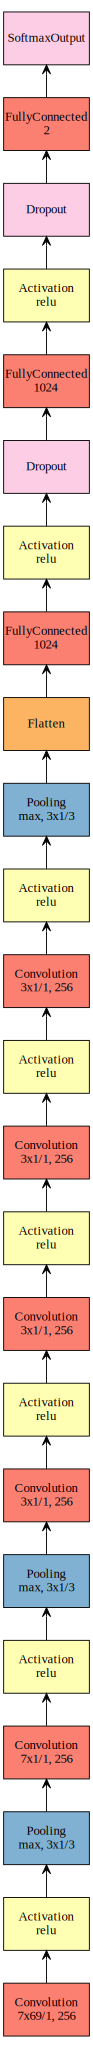

In [14]:
# Visualise symbol (for crepe)
crepe = create_crepe()

a = mx.viz.plot_network(crepe)
a.render('Crepe Model')
a

In [ ]:
train_x, train_y = load_data_frame('amazon_review_polarity_train.csv')

In [ ]:
print(train_x.shape)
print(train_y.shape)

In [17]:
train_iter = mx.io.NDArrayIter(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
del train_x
del train_y

In [13]:
model = mx.model.FeedForward(
    ctx = ctx,
    symbol = create_crepe(), 
    num_epoch = EPOCHS,  # number of training rounds
    learning_rate = LR,  # learning rate
    momentum = MOMENTUM,   # momentum for sgd
    wd = WDECAY,  # weight decay for reg
    initializer = INITY  # init with sd of 0.05
)

In [ ]:
tic = time.time()
model.fit(
    X = train_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("crepe_checkp_") 
)

print("Finished training in %.0f seconds" % (time.time() - tic))

In [ ]:
del train_iter

In [ ]:
"""
# GPU broke after completing 7th epoch
# Re-load checkpoint
# If training breaks (happens on GPU), we can train further like so:

# Load trained model:
pretrained_model = mx.model.FeedForward.load("crepe_checkp_v2_", 7)  

model = mx.model.FeedForward(
    ctx = ctx,
    symbol=pretrained_model.symbol,
    arg_params=pretrained_model.arg_params,
    aux_params=pretrained_model.aux_params,
    num_epoch=11, begin_epoch=7
)

# Train remaining epochs
tic = time.time()
model.fit(
    X = train_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(100*BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("crepe_checkp_v2_") 
)

print("Finished training in %.0f seconds" % (time.time() - tic))
"""

In [ ]:
# Load test data
test_x, test_y = load_data_frame('amazon_review_polarity_test.csv')
test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
# Predict
pred = np.argsort(model.predict(X = test_iter))[:,-1]

# Save Results
np.savetxt('crepe_predict_sentiment_amazon.csv', np.c_[pred, test_y], delimiter=',', fmt='%d')

In [22]:
# Accuracy
acc = sum(pred==test_y.astype('int'))/float(len(test_y))
logger.info(acc)
acc  # 0.94

0.94166495004634876

### Log Extract


```
2016-08-24 21:11:28,407 - root - INFO - Start training with [gpu(0)]
2016-08-24 21:12:40,015 - root - INFO - Epoch[0] Batch [50]	 Speed: 114.7797 samples/sec	Train-accuracy=0.502031
2016-08-24 21:13:15,326 - root - INFO - Epoch[0] Batch [100]	Speed: 181.3185 samples/sec	Train-accuracy=0.514531
2016-08-24 21:13:46,977 - root - INFO - Epoch[0] Batch [150]	Speed: 202.2053 samples/sec	Train-accuracy=0.515938
2016-08-24 21:14:17,447 - root - INFO - Epoch[0] Batch [200]	Speed: 210.0496 samples/sec	Train-accuracy=0.522344
2016-08-24 21:14:48,170 - root - INFO - Epoch[0] Batch [250]	Speed: 208.3130 samples/sec	Train-accuracy=0.540156
...
2016-08-26 20:53:13,394 - root - INFO - Epoch[10] Batch [16200]	Speed: 216.1578 samples/sec	Train-accuracy=0.967656
2016-08-26 20:53:43,127 - root - INFO - Epoch[10] Batch [16250]	Speed: 215.2490 samples/sec	Train-accuracy=0.970313
2016-08-26 20:54:11,734 - root - INFO - Epoch[10] Batch [16300]	Speed: 223.7136 samples/sec	Train-accuracy=0.967812
2016-08-26 20:54:40,546 - root - INFO - Epoch[10] Batch [16350]	Speed: 222.1374 samples/sec	Train-accuracy=0.971250
2016-08-26 20:55:00,513 - root - INFO - Epoch[10] Resetting Data Iterator
2016-08-26 20:55:00,513 - root - INFO - Epoch[10] Time cost=9474.580

2016-08-26 21:16:02,765 - root - INFO - 0.941664950046
```